# Support Vector Machine
## HiggsML Challenge

In [4]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Loading the data

In [5]:
dirName = '../../data/'
fileName = dirName + 'training.csv'
data = pd.read_csv(fileName)

## Data Preprocessing

In [6]:
# replace missing values with NaN
data = data.replace(-999.0, np.nan)

# learning data
X = data.copy()
del X['EventId']
del X['Weight']
del X['Label']
y = data['Label']
w = data['Weight']

In [7]:
# handle missing values
from sklearn.preprocessing import Imputer

# replace missing values with NaN
X = X.replace(-999.0, np.nan)

# missing_values is the value of your placeholder, strategy is if you'd like mean, median or mode, and axis=0 means it calculates the imputation based on the other feature values for that sample
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
imp.fit(X)
Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)
missingX = imp.transform(X)

In [8]:
# scale the data for SVM
from sklearn import preprocessing

def scale():
    scaler = preprocessing.StandardScaler()
    missingX_scaled = scaler.fit_transform(missingX)
    return missingX_scaled

missingX_scaled = scale()

In [49]:
# testing SVM
missingX_scaled.shape

(250000, 30)

In [48]:
# cheating for GBC test
X = X.replace(np.nan, -999.0)
missingX_scaled = X.copy()

## Splitting Training set to real training set and test set

In [9]:
Xtrain = missingX_scaled[1:225000]
Xtest = missingX_scaled[-25000:]
ytrain = y[1:225000]
ytest = y[-25000:]
wtrain = w[1:225000]
wtest = w[-25000:]
ytrainVals = ytrain.replace(to_replace=['s','b'],value=[1,0])

In [10]:
# minimal subset for faster learning of SVM.fit
Xtrain = missingX_scaled[1:25000]
ytrain = y[1:25000]
wtrain = w[1:25000]
ytrainVals = ytrain.replace(to_replace=['s','b'],value=[1,0])

## SVM

In [11]:
# import
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier as GBC

In [12]:
C = 1.0 

In [50]:
# SVM linear
clf = svm.SVC(kernel='linear',verbose=1) # probability=True, 
clf.fit(Xtrain, ytrainVals)

[LibSVM]

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=1)

In [55]:
# SVM polynomial
clf = svm.SVC(kernel='poly', degree=3, coef0=1.0,verbose=1)
clf.fit(Xtrain, ytrainVals)

[LibSVM]

SVC(C=1.0, cache_size=200, class_weight=None, coef0=1.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=1)

In [91]:
# SVM RBF
clf = svm.SVC(verbose=1)
clf.fit(Xtrain, ytrainVals)

[LibSVM]

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=1)

In [72]:
# normalized wtrain
wtrainNorm = wtrain / max(wtrain)
wtrainNorm = 1 - wtrainNorm

In [73]:
max(wtrainNorm)

0.99980757675436427

In [74]:
# SVM RBF with weights
clf = svm.SVC(verbose = 1)
clf.fit(Xtrain, ytrainVals, sample_weight = wtrainNorm)

[LibSVM]

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=1)

In [34]:
# SVM sigmoid
clf = svm.SVC(kernel='sigmoid', probability=True, verbose=1)
clf.fit(Xtrain, ytrainVals)

[LibSVM]

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='sigmoid',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=1)

In [51]:
# Gradint Boosting to test WTF is wrong
clf = GBC(n_estimators=50, max_depth=6,min_samples_leaf=200,max_features=30,verbose=1)
clf.fit(Xtrain,ytrainVals) 

      Iter       Train Loss   Remaining Time 
         1           1.2068            2.07m
         2           1.1438            2.00m
         3           1.0907            1.97m
         4           1.0469            1.91m
         5           1.0098            1.85m
         6           0.9780            1.82m
         7           0.9511            1.77m
         8           0.9273            1.73m
         9           0.9068            1.68m
        10           0.8890            1.64m
        20           0.7871            1.21m
        30           0.7469           50.87s
        40           0.7265           25.13s
        50           0.7136            0.00s


GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=6, max_features=30, max_leaf_nodes=None,
              min_samples_leaf=200, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              presort='auto', random_state=None, subsample=1.0, verbose=1,
              warm_start=False)

## Validation

In [29]:
# compute AMS
def ams(s, b):
    from math import sqrt,log
    if b==0:
        return 0

    return sqrt(2*((s+b+10)*log(1+float(s)/(b+10))-s))

In [30]:
# compute all measures
def validate(predicted, real, weights):
    sumsig = 0.
    sumbkg = 0.
    tp = 0.
    tn = 0.
    fp = 0.
    fn = 0.
    precision = 0.
    recall = 0.
    acc = 0.
    
    if (predicted.shape[0] != real.shape[0]):
        raise Exception
    
    for i in range(predicted.shape[0]):
        if predicted[i] == "s":
            if real[i] == "s":
                sumsig += weights[i]
                tp += 1
            else:
                sumbkg += weights[i]
                fp += 1
        else:
            if real[i] == "s":
                fn += 1
            else:
                tn += 1
    
    print(tp, fp, fn, tn)
    
    # calculate scores
    amsscore = ams(sumsig * 10, sumbkg * 10)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    acc = (tp + tn) / (tp + fp + tn + fn)
    f1score = (2 * precision * recall)/(precision + recall)

    printScores(tp, tn, fp, fn, precision, recall, acc, f1score, amsscore)
    
    return amsscore

In [31]:
def printScores(tp, tn, fp, fn, precision, recall, acc, f1score, amsscore):
    all = tp + tn + fp + fn
    print("TP: ", tp/all)
    print("TN: ", tn/all)
    print("FP: ", fp/all)
    print("FN: ", fn/all)
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("Acc: ", acc)
    print("F1: ", f1score)
    print("AMS: ", amsscore)

In [52]:
# validation
predicted = clf.predict(Xtest)
predictedV = pd.Series(predicted).map({1: 's', 0: 'b'})
validate(predictedV, np.array(ytest), np.array(wtest))

6197.0 1717.0 2412.0 14674.0
TP:  0.24788
TN:  0.58696
FP:  0.06868
FN:  0.09648
Precision:  0.783042709123073
Recall:  0.7198280868858171
Acc:  0.83484
F1:  0.7501059129697997
AMS:  2.813131802075169


2.813131802075169

## Explore features with Linear SVM

In [30]:
def plotWeights():
    barX = list(abs(clf.coef_[0]))[30:]
    barV = additionalNames
    cols = clf.coef_[0].shape[0] - 30
    ind = np.arange(cols)
    fig = plt.figure(figsize=(10,6)) 
    ax = fig.add_subplot(111)
    rects1 = ax.bar(ind, barX, width=0.6, align='center', color='b')
    #plt.yscale('log')
    #ax.set_xticklabels(barV)
    ax.set_xticks([])
    labels = ax.get_xticklabels()
    plt.setp(labels, rotation=90, fontsize=9)
    #plt.xticks(range(cols))
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='on') # labels along the bottom edge are off
    #ax.xaxis.set_major_locator(1)
    plt.xlim([-1,cols])
    plt.ylabel('Utež SVM')
    plt.tight_layout()
    plt.savefig('svm_weights_2xpoly2plusy2.pdf')

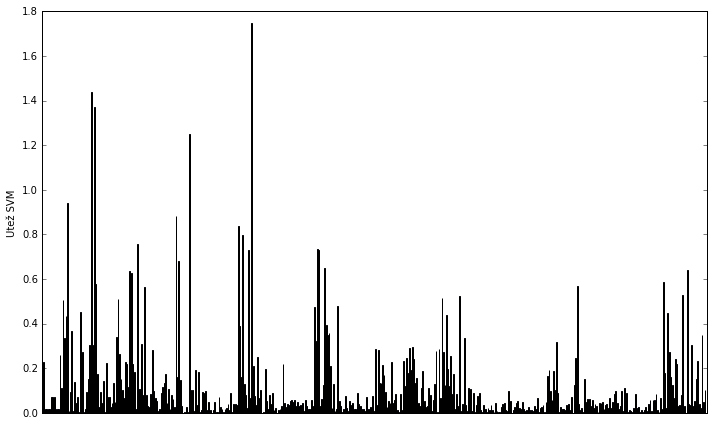

In [31]:
plotWeights()

In [32]:
def selectFeatures(n, threshold):
    barX = list(abs(clf.coef_[0]))[n:]
    cols = clf.coef_[0].shape[0] - n
    names = additionalNames[(n - 30):]
    selNames = []
    for i in range(cols):
        if (barX[i] > threshold):
            selNames.append(names[i])
    return(selNames)

In [36]:
selectFeatures(40, 0.8)

['Poly - DER_pt_h-DER_mass_vis',
 'Poly - DER_deltar_tau_lep-DER_mass_MMC',
 'Poly - DER_deltar_tau_lep-DER_mass_vis',
 'Poly - PRI_tau_pt-DER_mass_MMC',
 'Poly - PRI_tau_pt-DER_sum_pt',
 'Poly - PRI_lep_pt-DER_mass_MMC',
 'Poly - PRI_lep_pt-DER_sum_pt']

## Explore Features with Logistic Regression

In [255]:
# imports
from sklearn import linear_model

In [359]:
# model & fit
logistic = linear_model.LogisticRegression(C=1e5)
logistic.fit(Xtrain, ytrainVals)

LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [360]:
# validation
predicted = logistic.predict(Xtest)
predictedV = pd.Series(predicted).map({1: 's', 0: 'b'})
validate(predictedV, np.array(ytest), np.array(wtest))

5583.0 1987.0 3026.0 14404.0
TP:  0.22332
TN:  0.57616
FP:  0.07948
FN:  0.12104
Precision:  0.7375165125495377
Recall:  0.6485073760018585
Acc:  0.79948
F1:  0.690153903207862
AMS:  2.454486555742746


2.454486555742746

In [361]:
def plotWeights():
    barX = list(abs(logistic.coef_[0]))[30:]
    barV = additionalNames
    cols = logistic.coef_[0].shape[0] - 30
    ind = np.arange(cols)
    fig = plt.figure(figsize=(10,6)) 
    ax = fig.add_subplot(111)
    rects1 = ax.bar(ind, barX, width=0.6, align='center', color='b')
    #plt.yscale('log')
    ax.set_xticklabels(barV)
    labels = ax.get_xticklabels()
    plt.setp(labels, rotation=90, fontsize=9)
    plt.xticks(range(cols))
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='on') # labels along the bottom edge are off
    #ax.xaxis.set_major_locator(1)
    plt.xlim([-1,cols])
    plt.ylabel('Utež logistične regresije')
    plt.tight_layout()
    plt.savefig('lr_weights_x3x3.pdf')

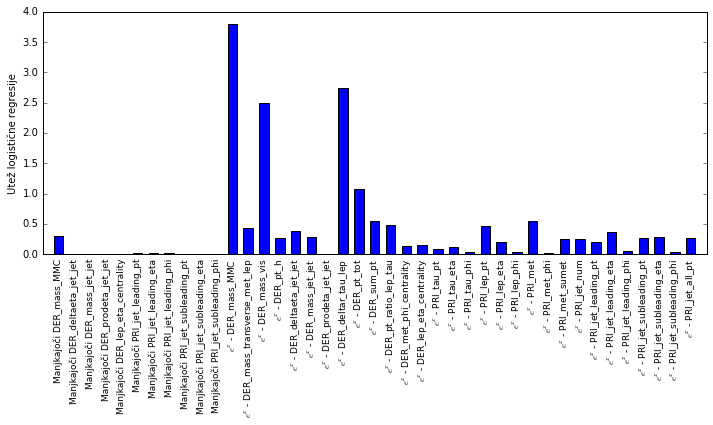

In [362]:
plotWeights()

## Expand Original feature set

In [7]:
# 1 - take original missingX
# 2 - add features based on X and missingX
# 3 - perform scaling
# 4 - use original code above (make sets + SVM)

# remember original missingX
originalMissingX = missingX.copy()

In [8]:
# add missing value information (1 present, 0 missing)
# functions
def hasNaN(name):
    values = list(np.isnan(X[name]).values)
    for i in values:
        if (i == True):
            return True
    return False

def addMissing():
    missX = missingX.copy()
    cols = list(X.columns.values)
    for col in cols:
        if hasNaN(col):
            print('Adding additional feature - missing value:', col)
            myCol = np.isnan(X[col]).map({True: 1, False: 0})
            missX = np.c_[missX, myCol]
            additionalNames.append("Manjkajoči " + col)
    return(missX)

In [9]:
missingX = originalMissingX.copy();
# add columns with missing number
additionalNames = [];
missX = addMissing()

Adding additional feature - missing value: DER_mass_MMC
Adding additional feature - missing value: DER_deltaeta_jet_jet
Adding additional feature - missing value: DER_mass_jet_jet
Adding additional feature - missing value: DER_prodeta_jet_jet
Adding additional feature - missing value: DER_lep_eta_centrality
Adding additional feature - missing value: PRI_jet_leading_pt
Adding additional feature - missing value: PRI_jet_leading_eta
Adding additional feature - missing value: PRI_jet_leading_phi
Adding additional feature - missing value: PRI_jet_subleading_pt
Adding additional feature - missing value: PRI_jet_subleading_eta
Adding additional feature - missing value: PRI_jet_subleading_phi


In [10]:
# write to the table
missingX = missX.copy()

In [11]:
def filterMissing(relevantMissing):
    missX = missingX.copy()
    newAdditionalNames = []
    deletedN = 0
    for x in additionalNames:
        if not (x in relevantMissing):
            nIndex = additionalNames.index(x) - deletedN
            aIndex = nIndex + 30 # we are keeping original features
            print(x)
            
            # remove column
            missX = np.delete(missX, aIndex, 1)
            deletedN = deletedN + 1
        else:
            newAdditionalNames.append(x)
                
    return(missX, newAdditionalNames)

In [12]:
# filter only relevant features
relevantMissing = ['Manjkajoči DER_mass_MMC']
missingX, additionalNames = filterMissing(relevantMissing)

Manjkajoči DER_deltaeta_jet_jet
Manjkajoči DER_mass_jet_jet
Manjkajoči DER_prodeta_jet_jet
Manjkajoči DER_lep_eta_centrality
Manjkajoči PRI_jet_leading_pt
Manjkajoči PRI_jet_leading_eta
Manjkajoči PRI_jet_leading_phi
Manjkajoči PRI_jet_subleading_pt
Manjkajoči PRI_jet_subleading_eta
Manjkajoči PRI_jet_subleading_phi


In [13]:
# add columns with x^2
def x2kernel(x):
    return(x*x)

In [14]:
def addOneX(name, kernel):
    missX = missingX.copy()
    cols = list(X.columns.values)
    i = 0
    for col in cols:
        myCol = kernel(missingX[:,i])
        print(name + ' ' + col)
        missX = np.c_[missX, myCol]
        additionalNames.append(name + " - " + col)
        i = i + 1
    return(missX)

def addOneXNormalized(name, kernel):
    missX = missingX.copy()
    cols = list(X.columns.values)
    i = 0
    for col in cols:
        myCol = kernel(missingX_scaled[:,i])
        print(name + ' ' + col)
        missX = np.c_[missX, myCol]
        additionalNames.append(name + " - " + col)
        i = i + 1
    return(missX)

In [15]:
missX = addOneX('$x^2$', x2kernel)

$x^2$ DER_mass_MMC
$x^2$ DER_mass_transverse_met_lep
$x^2$ DER_mass_vis
$x^2$ DER_pt_h
$x^2$ DER_deltaeta_jet_jet
$x^2$ DER_mass_jet_jet
$x^2$ DER_prodeta_jet_jet
$x^2$ DER_deltar_tau_lep
$x^2$ DER_pt_tot
$x^2$ DER_sum_pt
$x^2$ DER_pt_ratio_lep_tau
$x^2$ DER_met_phi_centrality
$x^2$ DER_lep_eta_centrality
$x^2$ PRI_tau_pt
$x^2$ PRI_tau_eta
$x^2$ PRI_tau_phi
$x^2$ PRI_lep_pt
$x^2$ PRI_lep_eta
$x^2$ PRI_lep_phi
$x^2$ PRI_met
$x^2$ PRI_met_phi
$x^2$ PRI_met_sumet
$x^2$ PRI_jet_num
$x^2$ PRI_jet_leading_pt
$x^2$ PRI_jet_leading_eta
$x^2$ PRI_jet_leading_phi
$x^2$ PRI_jet_subleading_pt
$x^2$ PRI_jet_subleading_eta
$x^2$ PRI_jet_subleading_phi
$x^2$ PRI_jet_all_pt


In [16]:
missingX = missX.copy()

In [17]:
# filter only relevant features
relevantMissing = relevantMissing + ['$x^2$ - DER_mass_MMC',
 '$x^2$ - DER_mass_vis',
 '$x^2$ - DER_deltar_tau_lep',
 '$x^2$ - DER_pt_tot',
 '$x^2$ - PRI_met']
missingX, additionalNames = filterMissing(relevantMissing)

$x^2$ - DER_mass_transverse_met_lep
$x^2$ - DER_pt_h
$x^2$ - DER_deltaeta_jet_jet
$x^2$ - DER_mass_jet_jet
$x^2$ - DER_prodeta_jet_jet
$x^2$ - DER_sum_pt
$x^2$ - DER_pt_ratio_lep_tau
$x^2$ - DER_met_phi_centrality
$x^2$ - DER_lep_eta_centrality
$x^2$ - PRI_tau_pt
$x^2$ - PRI_tau_eta
$x^2$ - PRI_tau_phi
$x^2$ - PRI_lep_pt
$x^2$ - PRI_lep_eta
$x^2$ - PRI_lep_phi
$x^2$ - PRI_met_phi
$x^2$ - PRI_met_sumet
$x^2$ - PRI_jet_num
$x^2$ - PRI_jet_leading_pt
$x^2$ - PRI_jet_leading_eta
$x^2$ - PRI_jet_leading_phi
$x^2$ - PRI_jet_subleading_pt
$x^2$ - PRI_jet_subleading_eta
$x^2$ - PRI_jet_subleading_phi
$x^2$ - PRI_jet_all_pt


In [120]:
# add columns with x^3
def x3kernel(x):
    return(x*x*x)
missX = addOneX('$x^3$', x3kernel)

$x^3$ DER_mass_MMC
$x^3$ DER_mass_transverse_met_lep
$x^3$ DER_mass_vis
$x^3$ DER_pt_h
$x^3$ DER_deltaeta_jet_jet
$x^3$ DER_mass_jet_jet
$x^3$ DER_prodeta_jet_jet
$x^3$ DER_deltar_tau_lep
$x^3$ DER_pt_tot
$x^3$ DER_sum_pt
$x^3$ DER_pt_ratio_lep_tau
$x^3$ DER_met_phi_centrality
$x^3$ DER_lep_eta_centrality
$x^3$ PRI_tau_pt
$x^3$ PRI_tau_eta
$x^3$ PRI_tau_phi
$x^3$ PRI_lep_pt
$x^3$ PRI_lep_eta
$x^3$ PRI_lep_phi
$x^3$ PRI_met
$x^3$ PRI_met_phi
$x^3$ PRI_met_sumet
$x^3$ PRI_jet_num
$x^3$ PRI_jet_leading_pt
$x^3$ PRI_jet_leading_eta
$x^3$ PRI_jet_leading_phi
$x^3$ PRI_jet_subleading_pt
$x^3$ PRI_jet_subleading_eta
$x^3$ PRI_jet_subleading_phi
$x^3$ PRI_jet_all_pt


In [19]:
missingX = missX.copy()

In [20]:
# filter only relevant features
relevantMissing = relevantMissing + ['$x^3$ - DER_mass_MMC',
 '$x^3$ - DER_mass_vis',
 '$x^3$ - DER_deltar_tau_lep',
 '$x^3$ - PRI_met']
missingX, additionalNames = filterMissing(relevantMissing)


$x^3$ - DER_mass_transverse_met_lep
$x^3$ - DER_pt_h
$x^3$ - DER_deltaeta_jet_jet
$x^3$ - DER_mass_jet_jet
$x^3$ - DER_prodeta_jet_jet
$x^3$ - DER_pt_tot
$x^3$ - DER_sum_pt
$x^3$ - DER_pt_ratio_lep_tau
$x^3$ - DER_met_phi_centrality
$x^3$ - DER_lep_eta_centrality
$x^3$ - PRI_tau_pt
$x^3$ - PRI_tau_eta
$x^3$ - PRI_tau_phi
$x^3$ - PRI_lep_pt
$x^3$ - PRI_lep_eta
$x^3$ - PRI_lep_phi
$x^3$ - PRI_met_phi
$x^3$ - PRI_met_sumet
$x^3$ - PRI_jet_num
$x^3$ - PRI_jet_leading_pt
$x^3$ - PRI_jet_leading_eta
$x^3$ - PRI_jet_leading_phi
$x^3$ - PRI_jet_subleading_pt
$x^3$ - PRI_jet_subleading_eta
$x^3$ - PRI_jet_subleading_phi
$x^3$ - PRI_jet_all_pt


In [18]:
# add columns with e^x
def exkernel(x):
    return(np.exp(x))
missX = addOneXNormalized('$e^x$', exkernel)

$e^x$ DER_mass_MMC
$e^x$ DER_mass_transverse_met_lep
$e^x$ DER_mass_vis
$e^x$ DER_pt_h
$e^x$ DER_deltaeta_jet_jet
$e^x$ DER_mass_jet_jet
$e^x$ DER_prodeta_jet_jet
$e^x$ DER_deltar_tau_lep
$e^x$ DER_pt_tot
$e^x$ DER_sum_pt
$e^x$ DER_pt_ratio_lep_tau
$e^x$ DER_met_phi_centrality
$e^x$ DER_lep_eta_centrality
$e^x$ PRI_tau_pt
$e^x$ PRI_tau_eta
$e^x$ PRI_tau_phi
$e^x$ PRI_lep_pt
$e^x$ PRI_lep_eta
$e^x$ PRI_lep_phi
$e^x$ PRI_met
$e^x$ PRI_met_phi
$e^x$ PRI_met_sumet
$e^x$ PRI_jet_num
$e^x$ PRI_jet_leading_pt
$e^x$ PRI_jet_leading_eta
$e^x$ PRI_jet_leading_phi
$e^x$ PRI_jet_subleading_pt
$e^x$ PRI_jet_subleading_eta
$e^x$ PRI_jet_subleading_phi
$e^x$ PRI_jet_all_pt


In [19]:
missingX = missX.copy()

In [20]:
# filter only relevant features
relevantMissing = relevantMissing + ['$e^x$ - DER_sum_pt', '$e^x$ - PRI_met_sumet']
missingX, additionalNames = filterMissing(relevantMissing)

$e^x$ - DER_mass_MMC
$e^x$ - DER_mass_transverse_met_lep
$e^x$ - DER_mass_vis
$e^x$ - DER_pt_h
$e^x$ - DER_deltaeta_jet_jet
$e^x$ - DER_mass_jet_jet
$e^x$ - DER_prodeta_jet_jet
$e^x$ - DER_deltar_tau_lep
$e^x$ - DER_pt_tot
$e^x$ - DER_pt_ratio_lep_tau
$e^x$ - DER_met_phi_centrality
$e^x$ - DER_lep_eta_centrality
$e^x$ - PRI_tau_pt
$e^x$ - PRI_tau_eta
$e^x$ - PRI_tau_phi
$e^x$ - PRI_lep_pt
$e^x$ - PRI_lep_eta
$e^x$ - PRI_lep_phi
$e^x$ - PRI_met
$e^x$ - PRI_met_phi
$e^x$ - PRI_jet_num
$e^x$ - PRI_jet_leading_pt
$e^x$ - PRI_jet_leading_eta
$e^x$ - PRI_jet_leading_phi
$e^x$ - PRI_jet_subleading_pt
$e^x$ - PRI_jet_subleading_eta
$e^x$ - PRI_jet_subleading_phi
$e^x$ - PRI_jet_all_pt


In [21]:
# add columns with sqrt(x)
def sqrtkernel(x):
    xArray = []
    for val in x:
        if (val > 0):
            xArray.append(np.sqrt(val))
        else:
            xArray.append(-np.sqrt(-val))
    return xArray;
missX = addOneX('$\sqrt{x}$', sqrtkernel)

$\sqrt{x}$ DER_mass_MMC
$\sqrt{x}$ DER_mass_transverse_met_lep
$\sqrt{x}$ DER_mass_vis
$\sqrt{x}$ DER_pt_h
$\sqrt{x}$ DER_deltaeta_jet_jet
$\sqrt{x}$ DER_mass_jet_jet
$\sqrt{x}$ DER_prodeta_jet_jet
$\sqrt{x}$ DER_deltar_tau_lep
$\sqrt{x}$ DER_pt_tot
$\sqrt{x}$ DER_sum_pt
$\sqrt{x}$ DER_pt_ratio_lep_tau
$\sqrt{x}$ DER_met_phi_centrality
$\sqrt{x}$ DER_lep_eta_centrality
$\sqrt{x}$ PRI_tau_pt
$\sqrt{x}$ PRI_tau_eta
$\sqrt{x}$ PRI_tau_phi
$\sqrt{x}$ PRI_lep_pt
$\sqrt{x}$ PRI_lep_eta
$\sqrt{x}$ PRI_lep_phi
$\sqrt{x}$ PRI_met
$\sqrt{x}$ PRI_met_phi
$\sqrt{x}$ PRI_met_sumet
$\sqrt{x}$ PRI_jet_num
$\sqrt{x}$ PRI_jet_leading_pt
$\sqrt{x}$ PRI_jet_leading_eta
$\sqrt{x}$ PRI_jet_leading_phi
$\sqrt{x}$ PRI_jet_subleading_pt
$\sqrt{x}$ PRI_jet_subleading_eta
$\sqrt{x}$ PRI_jet_subleading_phi
$\sqrt{x}$ PRI_jet_all_pt


In [22]:
missingX = missX.copy()

In [23]:
# filter only relevant features
relevantMissing = relevantMissing + ['$\\sqrt{x}$ - DER_mass_MMC',
 '$\\sqrt{x}$ - DER_mass_vis',
 '$\\sqrt{x}$ - DER_deltar_tau_lep',
 '$\\sqrt{x}$ - DER_pt_ratio_lep_tau',
 '$\\sqrt{x}$ - PRI_met']
missingX, additionalNames = filterMissing(relevantMissing)

$\sqrt{x}$ - DER_mass_transverse_met_lep
$\sqrt{x}$ - DER_pt_h
$\sqrt{x}$ - DER_deltaeta_jet_jet
$\sqrt{x}$ - DER_mass_jet_jet
$\sqrt{x}$ - DER_prodeta_jet_jet
$\sqrt{x}$ - DER_pt_tot
$\sqrt{x}$ - DER_sum_pt
$\sqrt{x}$ - DER_met_phi_centrality
$\sqrt{x}$ - DER_lep_eta_centrality
$\sqrt{x}$ - PRI_tau_pt
$\sqrt{x}$ - PRI_tau_eta
$\sqrt{x}$ - PRI_tau_phi
$\sqrt{x}$ - PRI_lep_pt
$\sqrt{x}$ - PRI_lep_eta
$\sqrt{x}$ - PRI_lep_phi
$\sqrt{x}$ - PRI_met_phi
$\sqrt{x}$ - PRI_met_sumet
$\sqrt{x}$ - PRI_jet_num
$\sqrt{x}$ - PRI_jet_leading_pt
$\sqrt{x}$ - PRI_jet_leading_eta
$\sqrt{x}$ - PRI_jet_leading_phi
$\sqrt{x}$ - PRI_jet_subleading_pt
$\sqrt{x}$ - PRI_jet_subleading_eta
$\sqrt{x}$ - PRI_jet_subleading_phi
$\sqrt{x}$ - PRI_jet_all_pt


In [766]:
# add columns with log(x)
def logkernel(x):
    xArray = []
    for val in x:
        if (val > 0):
            xArray.append(np.log(val))
        elif (val == 0):
            xArray.append(0.0)
        else:
            xArray.append(-np.log(-val))
    return xArray;
missX = addOneX('$\log{x}$', logkernel)

$\log{x}$ DER_mass_MMC
$\log{x}$ DER_mass_transverse_met_lep
$\log{x}$ DER_mass_vis
$\log{x}$ DER_pt_h
$\log{x}$ DER_deltaeta_jet_jet
$\log{x}$ DER_mass_jet_jet
$\log{x}$ DER_prodeta_jet_jet
$\log{x}$ DER_deltar_tau_lep
$\log{x}$ DER_pt_tot
$\log{x}$ DER_sum_pt
$\log{x}$ DER_pt_ratio_lep_tau
$\log{x}$ DER_met_phi_centrality
$\log{x}$ DER_lep_eta_centrality
$\log{x}$ PRI_tau_pt
$\log{x}$ PRI_tau_eta
$\log{x}$ PRI_tau_phi
$\log{x}$ PRI_lep_pt
$\log{x}$ PRI_lep_eta
$\log{x}$ PRI_lep_phi
$\log{x}$ PRI_met
$\log{x}$ PRI_met_phi
$\log{x}$ PRI_met_sumet
$\log{x}$ PRI_jet_num
$\log{x}$ PRI_jet_leading_pt
$\log{x}$ PRI_jet_leading_eta
$\log{x}$ PRI_jet_leading_phi
$\log{x}$ PRI_jet_subleading_pt
$\log{x}$ PRI_jet_subleading_eta
$\log{x}$ PRI_jet_subleading_phi
$\log{x}$ PRI_jet_all_pt


In [767]:
missingX = missX.copy()

In [700]:
# filter only relevant features
relevantMissing = relevantMissing + ['$\\log{x}$ - DER_mass_MMC',
 '$\\log{x}$ - DER_prodeta_jet_jet',
 '$\\log{x}$ - PRI_jet_subleading_phi']
missingX, additionalNames = filterMissing(relevantMissing)

$\log{x}$ - DER_mass_transverse_met_lep
$\log{x}$ - DER_mass_vis
$\log{x}$ - DER_pt_h
$\log{x}$ - DER_deltaeta_jet_jet
$\log{x}$ - DER_mass_jet_jet
$\log{x}$ - DER_deltar_tau_lep
$\log{x}$ - DER_pt_tot
$\log{x}$ - DER_sum_pt
$\log{x}$ - DER_pt_ratio_lep_tau
$\log{x}$ - DER_met_phi_centrality
$\log{x}$ - DER_lep_eta_centrality
$\log{x}$ - PRI_tau_pt
$\log{x}$ - PRI_tau_eta
$\log{x}$ - PRI_tau_phi
$\log{x}$ - PRI_lep_pt
$\log{x}$ - PRI_lep_eta
$\log{x}$ - PRI_lep_phi
$\log{x}$ - PRI_met
$\log{x}$ - PRI_met_phi
$\log{x}$ - PRI_met_sumet
$\log{x}$ - PRI_jet_num
$\log{x}$ - PRI_jet_leading_pt
$\log{x}$ - PRI_jet_leading_eta
$\log{x}$ - PRI_jet_leading_phi
$\log{x}$ - PRI_jet_subleading_pt
$\log{x}$ - PRI_jet_subleading_eta
$\log{x}$ - PRI_jet_all_pt


IndexError: index 51 is out of bounds for axis 1 with size 51

In [27]:
def addTwoX(name, kernel):
    missX = missingX.copy()
    cols = list(X.columns.values)
    colsN = X.columns.values.shape[0]
    i = 0
    for i in range(colsN):
        for j in range(i):
            name1 = cols[i]
            name2 = cols[j]
            colsName = name1 + '-' + name2
            print(name + ' ' + colsName)
            col1 = missingX_scaled[:,i]
            col2 = missingX_scaled[:,j]
            myCol = col1 * col2
            missX = np.c_[missX, myCol]
            additionalNames.append(name + " - " + colsName)            
    return(missX)

def dMultiKernel(x1, x2):
    return x1 * x2;

In [28]:
missX = addTwoX('Multi', dMultiKernel)

Multi DER_mass_transverse_met_lep-DER_mass_MMC
Multi DER_mass_vis-DER_mass_MMC
Multi DER_mass_vis-DER_mass_transverse_met_lep
Multi DER_pt_h-DER_mass_MMC
Multi DER_pt_h-DER_mass_transverse_met_lep
Multi DER_pt_h-DER_mass_vis
Multi DER_deltaeta_jet_jet-DER_mass_MMC
Multi DER_deltaeta_jet_jet-DER_mass_transverse_met_lep
Multi DER_deltaeta_jet_jet-DER_mass_vis
Multi DER_deltaeta_jet_jet-DER_pt_h
Multi DER_mass_jet_jet-DER_mass_MMC
Multi DER_mass_jet_jet-DER_mass_transverse_met_lep
Multi DER_mass_jet_jet-DER_mass_vis
Multi DER_mass_jet_jet-DER_pt_h
Multi DER_mass_jet_jet-DER_deltaeta_jet_jet
Multi DER_prodeta_jet_jet-DER_mass_MMC
Multi DER_prodeta_jet_jet-DER_mass_transverse_met_lep
Multi DER_prodeta_jet_jet-DER_mass_vis
Multi DER_prodeta_jet_jet-DER_pt_h
Multi DER_prodeta_jet_jet-DER_deltaeta_jet_jet
Multi DER_prodeta_jet_jet-DER_mass_jet_jet
Multi DER_deltar_tau_lep-DER_mass_MMC
Multi DER_deltar_tau_lep-DER_mass_transverse_met_lep
Multi DER_deltar_tau_lep-DER_mass_vis
Multi DER_deltar_ta

In [29]:
missingX = missX.copy()

In [30]:
# filter only relevant features
relevantMissing = relevantMissing + ['Multi - DER_mass_jet_jet-DER_mass_MMC',
 'Multi - DER_mass_jet_jet-DER_mass_vis',
 'Multi - DER_lep_eta_centrality-DER_mass_transverse_met_lep',
 'Multi - DER_lep_eta_centrality-DER_pt_ratio_lep_tau',
 'Multi - PRI_tau_phi-PRI_tau_pt',
 'Multi - PRI_jet_subleading_eta-PRI_tau_pt']
missingX, additionalNames = filterMissing(relevantMissing)

Multi - DER_mass_transverse_met_lep-DER_mass_MMC
Multi - DER_mass_vis-DER_mass_MMC
Multi - DER_mass_vis-DER_mass_transverse_met_lep
Multi - DER_pt_h-DER_mass_MMC
Multi - DER_pt_h-DER_mass_transverse_met_lep
Multi - DER_pt_h-DER_mass_vis
Multi - DER_deltaeta_jet_jet-DER_mass_MMC
Multi - DER_deltaeta_jet_jet-DER_mass_transverse_met_lep
Multi - DER_deltaeta_jet_jet-DER_mass_vis
Multi - DER_deltaeta_jet_jet-DER_pt_h
Multi - DER_mass_jet_jet-DER_mass_transverse_met_lep
Multi - DER_mass_jet_jet-DER_pt_h
Multi - DER_mass_jet_jet-DER_deltaeta_jet_jet
Multi - DER_prodeta_jet_jet-DER_mass_MMC
Multi - DER_prodeta_jet_jet-DER_mass_transverse_met_lep
Multi - DER_prodeta_jet_jet-DER_mass_vis
Multi - DER_prodeta_jet_jet-DER_pt_h
Multi - DER_prodeta_jet_jet-DER_deltaeta_jet_jet
Multi - DER_prodeta_jet_jet-DER_mass_jet_jet
Multi - DER_deltar_tau_lep-DER_mass_MMC
Multi - DER_deltar_tau_lep-DER_mass_transverse_met_lep
Multi - DER_deltar_tau_lep-DER_mass_vis
Multi - DER_deltar_tau_lep-DER_pt_h
Multi - DER

In [31]:
def dSquareSumKernel(x1, x2):
    return x1 * x1 + x2 * x2;
missX = addTwoX('SqSum', dSquareSumKernel)

SqSum DER_mass_transverse_met_lep-DER_mass_MMC
SqSum DER_mass_vis-DER_mass_MMC
SqSum DER_mass_vis-DER_mass_transverse_met_lep
SqSum DER_pt_h-DER_mass_MMC
SqSum DER_pt_h-DER_mass_transverse_met_lep
SqSum DER_pt_h-DER_mass_vis
SqSum DER_deltaeta_jet_jet-DER_mass_MMC
SqSum DER_deltaeta_jet_jet-DER_mass_transverse_met_lep
SqSum DER_deltaeta_jet_jet-DER_mass_vis
SqSum DER_deltaeta_jet_jet-DER_pt_h
SqSum DER_mass_jet_jet-DER_mass_MMC
SqSum DER_mass_jet_jet-DER_mass_transverse_met_lep
SqSum DER_mass_jet_jet-DER_mass_vis
SqSum DER_mass_jet_jet-DER_pt_h
SqSum DER_mass_jet_jet-DER_deltaeta_jet_jet
SqSum DER_prodeta_jet_jet-DER_mass_MMC
SqSum DER_prodeta_jet_jet-DER_mass_transverse_met_lep
SqSum DER_prodeta_jet_jet-DER_mass_vis
SqSum DER_prodeta_jet_jet-DER_pt_h
SqSum DER_prodeta_jet_jet-DER_deltaeta_jet_jet
SqSum DER_prodeta_jet_jet-DER_mass_jet_jet
SqSum DER_deltar_tau_lep-DER_mass_MMC
SqSum DER_deltar_tau_lep-DER_mass_transverse_met_lep
SqSum DER_deltar_tau_lep-DER_mass_vis
SqSum DER_deltar_ta

In [32]:
missingX = missX.copy()

In [33]:
# filter only relevant features
relevantMissing = relevantMissing + ['SqSum - DER_mass_jet_jet-DER_mass_MMC',
 'SqSum - DER_mass_jet_jet-DER_mass_vis',
 'SqSum - DER_lep_eta_centrality-DER_mass_transverse_met_lep',
 'SqSum - DER_lep_eta_centrality-DER_pt_ratio_lep_tau',
 'SqSum - PRI_tau_phi-PRI_tau_pt',
 'SqSum - PRI_jet_subleading_eta-PRI_tau_pt']
missingX, additionalNames = filterMissing(relevantMissing)



SqSum - DER_mass_transverse_met_lep-DER_mass_MMC
SqSum - DER_mass_vis-DER_mass_MMC
SqSum - DER_mass_vis-DER_mass_transverse_met_lep
SqSum - DER_pt_h-DER_mass_MMC
SqSum - DER_pt_h-DER_mass_transverse_met_lep
SqSum - DER_pt_h-DER_mass_vis
SqSum - DER_deltaeta_jet_jet-DER_mass_MMC
SqSum - DER_deltaeta_jet_jet-DER_mass_transverse_met_lep
SqSum - DER_deltaeta_jet_jet-DER_mass_vis
SqSum - DER_deltaeta_jet_jet-DER_pt_h
SqSum - DER_mass_jet_jet-DER_mass_transverse_met_lep
SqSum - DER_mass_jet_jet-DER_pt_h
SqSum - DER_mass_jet_jet-DER_deltaeta_jet_jet
SqSum - DER_prodeta_jet_jet-DER_mass_MMC
SqSum - DER_prodeta_jet_jet-DER_mass_transverse_met_lep
SqSum - DER_prodeta_jet_jet-DER_mass_vis
SqSum - DER_prodeta_jet_jet-DER_pt_h
SqSum - DER_prodeta_jet_jet-DER_deltaeta_jet_jet
SqSum - DER_prodeta_jet_jet-DER_mass_jet_jet
SqSum - DER_deltar_tau_lep-DER_mass_MMC
SqSum - DER_deltar_tau_lep-DER_mass_transverse_met_lep
SqSum - DER_deltar_tau_lep-DER_mass_vis
SqSum - DER_deltar_tau_lep-DER_pt_h
SqSum - DER

In [34]:
def dESquareSumKernel(x1, x2):
    return np.exp(x1 * x1 + x2 * x2);
missX = addTwoX('ESqSum', dESquareSumKernel)

ESqSum DER_mass_transverse_met_lep-DER_mass_MMC
ESqSum DER_mass_vis-DER_mass_MMC
ESqSum DER_mass_vis-DER_mass_transverse_met_lep
ESqSum DER_pt_h-DER_mass_MMC
ESqSum DER_pt_h-DER_mass_transverse_met_lep
ESqSum DER_pt_h-DER_mass_vis
ESqSum DER_deltaeta_jet_jet-DER_mass_MMC
ESqSum DER_deltaeta_jet_jet-DER_mass_transverse_met_lep
ESqSum DER_deltaeta_jet_jet-DER_mass_vis
ESqSum DER_deltaeta_jet_jet-DER_pt_h
ESqSum DER_mass_jet_jet-DER_mass_MMC
ESqSum DER_mass_jet_jet-DER_mass_transverse_met_lep
ESqSum DER_mass_jet_jet-DER_mass_vis
ESqSum DER_mass_jet_jet-DER_pt_h
ESqSum DER_mass_jet_jet-DER_deltaeta_jet_jet
ESqSum DER_prodeta_jet_jet-DER_mass_MMC
ESqSum DER_prodeta_jet_jet-DER_mass_transverse_met_lep
ESqSum DER_prodeta_jet_jet-DER_mass_vis
ESqSum DER_prodeta_jet_jet-DER_pt_h
ESqSum DER_prodeta_jet_jet-DER_deltaeta_jet_jet
ESqSum DER_prodeta_jet_jet-DER_mass_jet_jet
ESqSum DER_deltar_tau_lep-DER_mass_MMC
ESqSum DER_deltar_tau_lep-DER_mass_transverse_met_lep
ESqSum DER_deltar_tau_lep-DER_mass

In [35]:
missingX = missX.copy()

In [36]:
# filter only relevant features
relevantMissing = relevantMissing + ['ESqSum - DER_pt_h-DER_mass_vis',
 'ESqSum - DER_deltar_tau_lep-DER_mass_MMC',
 'ESqSum - DER_deltar_tau_lep-DER_mass_vis',
 'ESqSum - PRI_tau_pt-DER_mass_MMC',
 'ESqSum - PRI_tau_pt-DER_sum_pt',
 'ESqSum - PRI_lep_pt-DER_mass_MMC',
 'ESqSum - PRI_lep_pt-DER_sum_pt']
missingX, additionalNames = filterMissing(relevantMissing)


ESqSum - DER_mass_transverse_met_lep-DER_mass_MMC
ESqSum - DER_mass_vis-DER_mass_MMC
ESqSum - DER_mass_vis-DER_mass_transverse_met_lep
ESqSum - DER_pt_h-DER_mass_MMC
ESqSum - DER_pt_h-DER_mass_transverse_met_lep
ESqSum - DER_deltaeta_jet_jet-DER_mass_MMC
ESqSum - DER_deltaeta_jet_jet-DER_mass_transverse_met_lep
ESqSum - DER_deltaeta_jet_jet-DER_mass_vis
ESqSum - DER_deltaeta_jet_jet-DER_pt_h
ESqSum - DER_mass_jet_jet-DER_mass_MMC
ESqSum - DER_mass_jet_jet-DER_mass_transverse_met_lep
ESqSum - DER_mass_jet_jet-DER_mass_vis
ESqSum - DER_mass_jet_jet-DER_pt_h
ESqSum - DER_mass_jet_jet-DER_deltaeta_jet_jet
ESqSum - DER_prodeta_jet_jet-DER_mass_MMC
ESqSum - DER_prodeta_jet_jet-DER_mass_transverse_met_lep
ESqSum - DER_prodeta_jet_jet-DER_mass_vis
ESqSum - DER_prodeta_jet_jet-DER_pt_h
ESqSum - DER_prodeta_jet_jet-DER_deltaeta_jet_jet
ESqSum - DER_prodeta_jet_jet-DER_mass_jet_jet
ESqSum - DER_deltar_tau_lep-DER_mass_transverse_met_lep
ESqSum - DER_deltar_tau_lep-DER_pt_h
ESqSum - DER_deltar_tau

In [37]:
def dSqrtSquareSumKernel(x1, x2):
    return np.sqrt(x1 * x1 + x2 * x2);
missX = addTwoX('SqrtSqSum', dSqrtSquareSumKernel)


SqrtSqSum DER_mass_transverse_met_lep-DER_mass_MMC
SqrtSqSum DER_mass_vis-DER_mass_MMC
SqrtSqSum DER_mass_vis-DER_mass_transverse_met_lep
SqrtSqSum DER_pt_h-DER_mass_MMC
SqrtSqSum DER_pt_h-DER_mass_transverse_met_lep
SqrtSqSum DER_pt_h-DER_mass_vis
SqrtSqSum DER_deltaeta_jet_jet-DER_mass_MMC
SqrtSqSum DER_deltaeta_jet_jet-DER_mass_transverse_met_lep
SqrtSqSum DER_deltaeta_jet_jet-DER_mass_vis
SqrtSqSum DER_deltaeta_jet_jet-DER_pt_h
SqrtSqSum DER_mass_jet_jet-DER_mass_MMC
SqrtSqSum DER_mass_jet_jet-DER_mass_transverse_met_lep
SqrtSqSum DER_mass_jet_jet-DER_mass_vis
SqrtSqSum DER_mass_jet_jet-DER_pt_h
SqrtSqSum DER_mass_jet_jet-DER_deltaeta_jet_jet
SqrtSqSum DER_prodeta_jet_jet-DER_mass_MMC
SqrtSqSum DER_prodeta_jet_jet-DER_mass_transverse_met_lep
SqrtSqSum DER_prodeta_jet_jet-DER_mass_vis
SqrtSqSum DER_prodeta_jet_jet-DER_pt_h
SqrtSqSum DER_prodeta_jet_jet-DER_deltaeta_jet_jet
SqrtSqSum DER_prodeta_jet_jet-DER_mass_jet_jet
SqrtSqSum DER_deltar_tau_lep-DER_mass_MMC
SqrtSqSum DER_deltar_t

In [38]:
missingX = missX.copy()

In [39]:
# filter only relevant features
relevantMissing = relevantMissing + ['SqrtSqSum - DER_mass_jet_jet-DER_mass_MMC',
 'SqrtSqSum - DER_mass_jet_jet-DER_mass_vis',
 'SqrtSqSum - DER_lep_eta_centrality-DER_mass_transverse_met_lep',
 'SqrtSqSum - DER_lep_eta_centrality-DER_pt_ratio_lep_tau',
 'SqrtSqSum - PRI_tau_phi-PRI_tau_pt',
 'SqrtSqSum - PRI_jet_subleading_eta-PRI_tau_pt']
missingX, additionalNames = filterMissing(relevantMissing)

SqrtSqSum - DER_mass_transverse_met_lep-DER_mass_MMC
SqrtSqSum - DER_mass_vis-DER_mass_MMC
SqrtSqSum - DER_mass_vis-DER_mass_transverse_met_lep
SqrtSqSum - DER_pt_h-DER_mass_MMC
SqrtSqSum - DER_pt_h-DER_mass_transverse_met_lep
SqrtSqSum - DER_pt_h-DER_mass_vis
SqrtSqSum - DER_deltaeta_jet_jet-DER_mass_MMC
SqrtSqSum - DER_deltaeta_jet_jet-DER_mass_transverse_met_lep
SqrtSqSum - DER_deltaeta_jet_jet-DER_mass_vis
SqrtSqSum - DER_deltaeta_jet_jet-DER_pt_h
SqrtSqSum - DER_mass_jet_jet-DER_mass_transverse_met_lep
SqrtSqSum - DER_mass_jet_jet-DER_pt_h
SqrtSqSum - DER_mass_jet_jet-DER_deltaeta_jet_jet
SqrtSqSum - DER_prodeta_jet_jet-DER_mass_MMC
SqrtSqSum - DER_prodeta_jet_jet-DER_mass_transverse_met_lep
SqrtSqSum - DER_prodeta_jet_jet-DER_mass_vis
SqrtSqSum - DER_prodeta_jet_jet-DER_pt_h
SqrtSqSum - DER_prodeta_jet_jet-DER_deltaeta_jet_jet
SqrtSqSum - DER_prodeta_jet_jet-DER_mass_jet_jet
SqrtSqSum - DER_deltar_tau_lep-DER_mass_MMC
SqrtSqSum - DER_deltar_tau_lep-DER_mass_transverse_met_lep
Sqr

In [40]:
def dPolyKernel(x1, x2):
    return np.sqr(1 + x1 * x2);
missX = addTwoX('Poly', dPolyKernel)

Poly DER_mass_transverse_met_lep-DER_mass_MMC
Poly DER_mass_vis-DER_mass_MMC
Poly DER_mass_vis-DER_mass_transverse_met_lep
Poly DER_pt_h-DER_mass_MMC
Poly DER_pt_h-DER_mass_transverse_met_lep
Poly DER_pt_h-DER_mass_vis
Poly DER_deltaeta_jet_jet-DER_mass_MMC
Poly DER_deltaeta_jet_jet-DER_mass_transverse_met_lep
Poly DER_deltaeta_jet_jet-DER_mass_vis
Poly DER_deltaeta_jet_jet-DER_pt_h
Poly DER_mass_jet_jet-DER_mass_MMC
Poly DER_mass_jet_jet-DER_mass_transverse_met_lep
Poly DER_mass_jet_jet-DER_mass_vis
Poly DER_mass_jet_jet-DER_pt_h
Poly DER_mass_jet_jet-DER_deltaeta_jet_jet
Poly DER_prodeta_jet_jet-DER_mass_MMC
Poly DER_prodeta_jet_jet-DER_mass_transverse_met_lep
Poly DER_prodeta_jet_jet-DER_mass_vis
Poly DER_prodeta_jet_jet-DER_pt_h
Poly DER_prodeta_jet_jet-DER_deltaeta_jet_jet
Poly DER_prodeta_jet_jet-DER_mass_jet_jet
Poly DER_deltar_tau_lep-DER_mass_MMC
Poly DER_deltar_tau_lep-DER_mass_transverse_met_lep
Poly DER_deltar_tau_lep-DER_mass_vis
Poly DER_deltar_tau_lep-DER_pt_h
Poly DER_d

In [41]:
missingX = missX.copy()

In [42]:
# filter only relevant features
relevantMissing = relevantMissing + ['Poly - DER_pt_h-DER_mass_vis',
 'Poly - DER_deltar_tau_lep-DER_mass_MMC',
 'Poly - DER_deltar_tau_lep-DER_mass_vis',
 'Poly - PRI_tau_pt-DER_mass_MMC',
 'Poly - PRI_tau_pt-DER_sum_pt',
 'Poly - PRI_lep_pt-DER_mass_MMC',
 'Poly - PRI_lep_pt-DER_sum_pt']
missingX, additionalNames = filterMissing(relevantMissing)

Poly - DER_mass_transverse_met_lep-DER_mass_MMC
Poly - DER_mass_vis-DER_mass_MMC
Poly - DER_mass_vis-DER_mass_transverse_met_lep
Poly - DER_pt_h-DER_mass_MMC
Poly - DER_pt_h-DER_mass_transverse_met_lep
Poly - DER_deltaeta_jet_jet-DER_mass_MMC
Poly - DER_deltaeta_jet_jet-DER_mass_transverse_met_lep
Poly - DER_deltaeta_jet_jet-DER_mass_vis
Poly - DER_deltaeta_jet_jet-DER_pt_h
Poly - DER_mass_jet_jet-DER_mass_MMC
Poly - DER_mass_jet_jet-DER_mass_transverse_met_lep
Poly - DER_mass_jet_jet-DER_mass_vis
Poly - DER_mass_jet_jet-DER_pt_h
Poly - DER_mass_jet_jet-DER_deltaeta_jet_jet
Poly - DER_prodeta_jet_jet-DER_mass_MMC
Poly - DER_prodeta_jet_jet-DER_mass_transverse_met_lep
Poly - DER_prodeta_jet_jet-DER_mass_vis
Poly - DER_prodeta_jet_jet-DER_pt_h
Poly - DER_prodeta_jet_jet-DER_deltaeta_jet_jet
Poly - DER_prodeta_jet_jet-DER_mass_jet_jet
Poly - DER_deltar_tau_lep-DER_mass_transverse_met_lep
Poly - DER_deltar_tau_lep-DER_pt_h
Poly - DER_deltar_tau_lep-DER_deltaeta_jet_jet
Poly - DER_deltar_ta

In [ ]:
# razširjen nabor poly značilk
['Poly - DER_mass_vis-DER_mass_transverse_met_lep',
 'Poly - DER_pt_h-DER_mass_vis',
 'Poly - DER_deltar_tau_lep-DER_mass_MMC',
 'Poly - DER_deltar_tau_lep-DER_mass_vis',
 'Poly - DER_deltar_tau_lep-DER_pt_h',
 'Poly - DER_sum_pt-DER_pt_h',
 'Poly - DER_pt_ratio_lep_tau-DER_mass_vis',
 'Poly - DER_pt_ratio_lep_tau-DER_pt_h',
 'Poly - DER_pt_ratio_lep_tau-DER_deltar_tau_lep',
 'Poly - DER_met_phi_centrality-DER_mass_vis',
 'Poly - PRI_tau_pt-DER_mass_MMC',
 'Poly - PRI_tau_pt-DER_mass_vis',
 'Poly - PRI_tau_pt-DER_sum_pt',
 'Poly - PRI_lep_pt-DER_mass_MMC',
 'Poly - PRI_lep_pt-DER_pt_h',
 'Poly - PRI_lep_pt-DER_deltar_tau_lep',
 'Poly - PRI_lep_pt-DER_sum_pt',
 'Poly - PRI_met-DER_mass_vis',
 'Poly - PRI_met-DER_pt_h',
 'Poly - PRI_met-DER_deltar_tau_lep',
 'Poly - PRI_jet_leading_pt-DER_deltaeta_jet_jet',
 'Poly - PRI_jet_leading_pt-PRI_lep_pt',
 'Poly - PRI_jet_subleading_pt-PRI_jet_leading_pt',
 'Poly - PRI_jet_all_pt-DER_mass_MMC',
 'Poly - PRI_jet_all_pt-PRI_tau_pt',
 'Poly - PRI_jet_all_pt-PRI_lep_pt']

In [80]:
# KMeans adding
from sklearn import metrics
from sklearn.cluster import KMeans

est = KMeans(init='k-means++', n_clusters = 20)
est.fit(missingX)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=20, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [83]:
est.labels_

array([15, 15, 15, ...,  0, 19,  0])

In [84]:
missX = missingX.copy()
missX = np.c_[missX, est.labels_]
additionalNames.append("KM cluster")                

In [86]:
missingX = missX.copy()

In [33]:
col1 = missingX_scaled[:,0]
col2 = missingX_scaled[:,1]
myCol = col1 * col2

In [34]:
col1

array([ 0.31491066,  0.74082703,  0.        , ..., -0.31093067,
       -0.51009733,  0.        ])

In [35]:
col2

array([ 0.06833197,  0.55250482,  3.19515553, ...,  0.31931645,
       -0.84532397,  0.66533608])

In [36]:
myCol

array([ 0.02151846,  0.40931051,  0.        , ..., -0.09928528,
        0.4311975 ,  0.        ])